In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# os.environ['TRITON_INTERPRET'] = '1'

import torch

import os
import triton
import triton.language as tl
# import math

DEVICE = triton.runtime.driver.active.get_active_torch_device()

if torch.cuda.is_available():
    device = torch.cuda.current_device()
    props = torch.cuda.get_device_properties(device)
    
    print(f"Device: {props.name}")
    print(f"Compute Capability: {props.major}.{props.minor}")
    print(f"Total Memory: {props.total_memory / 1024**3:.2f} GB")
    # print(f"CUDA Cores: {props.multi_processor_count}")

Device: NVIDIA GeForce RTX 5070 Ti
Compute Capability: 12.0
Total Memory: 15.45 GB


In [2]:
def get_configs_decode():
    configs = []
    for num_warps, num_stages in [
        (4, 2),
        (4, 3),
        (4, 4),
    ]:
        for BLOCK_SIZE_M in [16, 32]:
            for BLOCK_SIZE_N in [32, 64, 128]:
                for BLOCK_SIZE_K in [128, 256, 512]:
                    configs.append(
                        triton.Config(
                            {
                                "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                            },
                            num_stages=num_stages, 
                            num_warps=num_warps
                        ),
                    )
    return configs


def get_configs_prefill():
    configs = []
    for num_warps, num_stages in [
        # (4, 2),
        (4, 3),
        # (4, 4),
    ]:
        for BLOCK_SIZE_M in [128, 256]:
            for BLOCK_SIZE_N in [32, 64, 128]:
                for BLOCK_SIZE_K in [32, 64, 128]:
                    configs.append(
                        triton.Config(
                            {
                                "BLOCK_SIZE_M" : BLOCK_SIZE_M,
                                "BLOCK_SIZE_N" : BLOCK_SIZE_N,
                                "BLOCK_SIZE_K" : BLOCK_SIZE_K,
                            },
                            num_stages=num_stages, 
                            num_warps=num_warps
                        ),
                    )
    return configs

    # return [triton.Config(
    #                             {
    #                                 "BLOCK_SIZE_M" : 16,
    #                                 "BLOCK_SIZE_N" : 64,
    #                                 "BLOCK_SIZE_K" : 64,
    #                             },
    #                             num_stages=4,
    #                             num_warps=4
    #                         )]


@triton.jit()
def get_pid_point_base(
        pid,
        M, N,
        BLOCK_SIZE_M: tl.constexpr,
        BLOCK_SIZE_N: tl.constexpr,
    ):
    grid_n = tl.cdiv(N, BLOCK_SIZE_N)
    pid_m = pid // grid_n
    pid_n = pid % grid_n
    return pid_m, pid_n


@triton.jit()
def get_pid_point_grouped(
        pid,
        M, N,
        BLOCK_SIZE_M: tl.constexpr,
        BLOCK_SIZE_N: tl.constexpr,
    ):
    
    grid_m = tl.cdiv(M, BLOCK_SIZE_M)
    grid_n = tl.cdiv(N, BLOCK_SIZE_N)

    width = 8 * grid_n
    group_id = pid // width
    group_size = tl.minimum(grid_m - group_id * 8, 8)

    pid_m = group_id * 8 + (pid % group_size)
    pid_n = (pid % width) // group_size

    return pid_m, pid_n

In [3]:
def get_cuda_autotune_config():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 256, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 128, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4)
    ]


@triton.autotune(
    configs=get_cuda_autotune_config(),
    key=['M', 'N', 'K'],
)
@triton.jit
def matmul_kernel(
        a_ptr, b_ptr, c_ptr,
        M, N, K,
        stride_am, stride_ak,
        stride_bk, stride_bn,
        stride_cm, stride_cn,
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """

    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)


    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        accumulator = tl.dot(a, b, accumulator)
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk

    c = accumulator.to(tl.float16)

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


def matmul_fp8(a, b):
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape

    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    matmul_kernel[grid](
        a, b, c,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    return c

In [4]:
@triton.autotune(
    configs=get_configs_prefill(),
    key=['M', 'N', 'K'],
)
@triton.jit
def MATMUL_W4C_A8C_FP8_prefill(
        a_ptr, b_ptr, c_ptr, scale_ptr,
        M, N, K,
        stride_am, stride_ak,
        stride_bk, stride_bn,
        stride_cm, stride_cn,
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
):

    pid = tl.program_id(axis=0)
    
    pid_m, pid_n = get_pid_point_grouped(
    # pid_m, pid_n = get_pid_point_base(
        pid,
        M, N,
        BLOCK_SIZE_M,
        BLOCK_SIZE_N
    )

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_scale = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    scale_ptrs = scale_ptr + offs_scale
    scale = tl.load(scale_ptrs, mask=offs_scale < N)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bk = tl.arange(0, BLOCK_SIZE_K // 8)
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    b_ptrs = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn[None, :] * stride_bn)

    shifter = tl.arange(0, 8) * 4

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    for k_idx in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        k_offset = k_idx * BLOCK_SIZE_K
        
        a_mask = (offs_am[:, None] < M) & (offs_k[None, :] + k_offset < K)
        b_mask = (offs_bn[None, :] < N) & ((offs_bk[:, None] + (k_offset // 8)) < K // 8)
        a = tl.load(a_ptrs + k_offset * stride_ak, mask=a_mask, other=0.0)
        b_bits = tl.load(b_ptrs + (k_offset // 8) * stride_bk, mask=b_mask, other=0)

        b = (b_bits[:, None, :] >> shifter[None, :, None]) & 0xF
        b = (b - 7.5).to(tl.float8e4nv)
        b = tl.reshape(b, (BLOCK_SIZE_K, BLOCK_SIZE_N))

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)


    accumulator = accumulator * scale[None, :]

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def matmul_w4c_a8c_fp8_prefill(a, b, scale):
    assert a.shape[1] == b.shape[0] * 8, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    # assert a.dtype == torch.float8_e5m2
    assert b.dtype == torch.int32
    
    M, K = a.shape
    N = b.shape[1]

    assert scale.dtype == torch.float16
    assert len(scale.shape) == 1
    assert scale.shape[0] == N

    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    MATMUL_W4C_A8C_FP8_prefill[grid](
        a, b, c, scale,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    return c


In [5]:
@triton.autotune(
    configs=get_configs_prefill(),
    key=['M', 'N', 'K'],
)
@triton.jit
def MATMUL_W4C_A8C_FP8(
        a_ptr, b_ptr, c_ptr, scale_ptr,
        M, N, K,
        stride_am, stride_ak,
        stride_bk, stride_bn,
        stride_cm, stride_cn,
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
):

    pid = tl.program_id(axis=0)
    
    pid_m, pid_n = get_pid_point_grouped(
    # pid_m, pid_n = get_pid_point_base(
        pid,
        M, N,
        BLOCK_SIZE_M,
        BLOCK_SIZE_N
    )

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_scale = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    scale_ptrs = scale_ptr + offs_scale
    scale = tl.load(scale_ptrs, mask=offs_scale < N)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bk = tl.arange(0, BLOCK_SIZE_K // 8)
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    b_ptrs = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn[None, :] * stride_bn)

    shifter = tl.arange(0, 8) * 4

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    a_mask0 = (offs_am[:, None] < M) & (offs_k[None, :] < K)
    b_mask0 = (offs_bn[None, :] < N) & ((offs_bk[:, None]) < K // 8)
    a = tl.load(a_ptrs, mask=a_mask0, other=0.0, eviction_policy="evict_last")
    b_bits = tl.load(b_ptrs, mask=b_mask0, other=0)
    for k_idx in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        next_k_offset = (k_idx + 1) * BLOCK_SIZE_K
        
        if k_idx + 1 < tl.cdiv(K, BLOCK_SIZE_K):
            a_next_mask = (offs_am[:, None] < M) & (offs_k[None, :] + next_k_offset < K)
            b_next_mask = (offs_bn[None, :] < N) & ((offs_bk[:, None] + (next_k_offset // 8)) < K // 8)
            a_next = tl.load(a_ptrs + next_k_offset * stride_ak, mask=a_next_mask, other=0.0, eviction_policy="evict_last")
            b_bits_next = tl.load(b_ptrs + (next_k_offset // 8) * stride_bk, mask=b_next_mask, other=0)
        else:
            a_next = tl.zeros_like(a)
            b_bits_next = tl.zeros_like(b_bits)

        b = (b_bits[:, None, :] >> shifter[None, :, None]) & 0xF
        b = tl.reshape(b, (BLOCK_SIZE_K, BLOCK_SIZE_N))
        b = (b.to(tl.float16) - 7.5).to(tl.float8e5)

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)

        a = a_next
        b_bits = b_bits_next

    accumulator = accumulator * scale[None, :]

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def matmul_w4c_a8c_fp8(a, b, scale):
    assert a.shape[1] == b.shape[0] * 8, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float8_e5m2
    assert b.dtype == torch.int32
    
    M, K = a.shape
    N = b.shape[1]

    assert scale.dtype == torch.float16
    assert len(scale.shape) == 1
    assert scale.shape[0] == N

    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    MATMUL_W4C_A8C_FP8[grid](
        a, b, c, scale,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    return c


In [6]:
@triton.autotune(
    configs=get_configs_prefill(),
    key=['M', 'N', 'K'],
)
@triton.jit
def MATMUL_W4C_A8C_FP8_test(
        a_ptr, b_ptr, c_ptr, scale_ptr,
        M, N, K,
        stride_am, stride_ak,
        stride_bk, stride_bn,
        stride_cm, stride_cn,
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
):

    pid = tl.program_id(axis=0)
    
    pid_m, pid_n = get_pid_point_grouped(
    # pid_m, pid_n = get_pid_point_base(
        pid,
        M, N,
        BLOCK_SIZE_M,
        BLOCK_SIZE_N
    )

    tl.assume(pid_m >= 0)
    tl.assume(pid_n >= 0)
    tl.assume(stride_am > 0)
    tl.assume(stride_ak > 0)
    tl.assume(stride_bn > 0)
    tl.assume(stride_bk > 0)
    tl.assume(stride_cm > 0)
    tl.assume(stride_cn > 0)

    offs_scale = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    scale_ptrs = scale_ptr + offs_scale
    scale = tl.load(scale_ptrs, mask=offs_scale < N)

    offs_k = tl.arange(0, BLOCK_SIZE_K)
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    
    offs_bk = tl.arange(0, BLOCK_SIZE_K // 2)
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    b_ptrs = b_ptr + ((offs_bk[:, None]) * stride_bk + offs_bn[None, :] * stride_bn)

    accumulator_dtype = tl.float32
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=accumulator_dtype)

    for k_idx in tl.range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        k_offset = k_idx * BLOCK_SIZE_K
        
        a_mask = (offs_am[:, None] < M) & (offs_k[None, :] + k_offset < K)
        b_mask = (offs_bn[None, :] < N) & ((offs_bk[:, None] + (k_offset // 2)) < K // 2)
        a = tl.load(a_ptrs + k_offset * stride_ak, mask=a_mask, other=0.0)
        b_bits = tl.load(b_ptrs + (k_offset // 2) * stride_bk, mask=b_mask, other=0)

        b = tl.join(b_bits & 0xF, (b_bits >> 4) & 0xF)
        b = tl.reshape(b, (BLOCK_SIZE_K, BLOCK_SIZE_N))
        b = b.to(tl.float8e5, bitcast=True)

        accumulator = tl.dot(a, b, accumulator, out_dtype=accumulator_dtype)


    accumulator = accumulator * scale[None, :]

    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, accumulator.to(tl.float16), mask=c_mask)


def matmul_w4c_a8c_fp8_test(a, b, scale):
    assert a.shape[1] == b.shape[0] * 2, "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"

    assert a.dtype == torch.float8_e5m2
    assert b.dtype == torch.int8
    
    M, K = a.shape
    N = b.shape[1]

    assert scale.dtype == torch.float16
    assert len(scale.shape) == 1
    assert scale.shape[0] == N

    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    MATMUL_W4C_A8C_FP8_test[grid](
        a, b, c, scale,
        M, N, K,
        a.stride(0), a.stride(1),
        b.stride(0), b.stride(1),
        c.stride(0), c.stride(1),
    )
    return c


In [7]:
def W4C_A8C_FP8_get_matrix(x_compressed):
    K, N = x_compressed.shape[0] * 8, x_compressed.shape[1] 
    shifter = (torch.arange(0, 8) * 4).cuda()
    x_decompressed = (x_compressed[:, None, :] >> shifter[None, :, None]) & 0xF
    x_decompressed = x_decompressed.reshape(K, N).to(torch.float16) - 7.5
    return x_decompressed.to(torch.float8_e5m2)

In [8]:
@torch.no_grad()
def deepseek_dist(x, y):
    x, y = x.double(), y.double()
    denom = (x * x + y * y).sum()
    sim = 2 * (x * y).sum() / denom
    return 1 - sim

In [9]:
def run_test(M, K, N):
    y_fp8 = torch.randn(M, K, dtype=torch.float16, device="cuda").to(torch.float8_e5m2)
    x_compressed_4bit = torch.randint(-2**31, 2**31, (K // 8, N), dtype=torch.int32, device="cuda")
    channel_scale = torch.randn(N, dtype=torch.float16, device="cuda").abs()

    x_decompressed = W4C_A8C_FP8_get_matrix(x_compressed_4bit)
    torch_out = y_fp8.float() @ x_decompressed.float() * channel_scale[None, :]
    triton_out = matmul_w4c_a8c_fp8_prefill(y_fp8, x_compressed_4bit, channel_scale)

    dist = deepseek_dist(triton_out, torch_out)
    print(f"[M x K x N]: [{M} x {K} x {N}], dist = {dist}")
    assert dist < 0.001

In [10]:
# M, K, N = 512, 1024, 2048
# run_test(M, K, N)


[M x K x N]: [512 x 2048 x 2048]
MATMUL_W4C_A8C_FP8_prefill: BLOCK_SIZE_M: 256, BLOCK_SIZE_N: 32, BLOCK_SIZE_K: 64, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None

[M x K x N]: [512 x 4096 x 4096]
MATMUL_W4C_A8C_FP8_prefill: BLOCK_SIZE_M: 256, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 64, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None

[M x K x N]: [512 x 8192 x 8192]
MATMUL_W4C_A8C_FP8_prefill: BLOCK_SIZE_M: 256, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 64, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None

[M x K x N]: [512 x 16384 x 16384]
MATMUL_W4C_A8C_FP8_prefill: BLOCK_SIZE_M: 128, BLOCK_SIZE_N: 64, BLOCK_SIZE_K: 64, num_warps: 4, num_ctas: 1, num_stages: 3, maxnreg: None
matmul-performance:
         K      M        N  torch_fp16  triton_matmul_w4c_a8c_fp8_prefill
0   2048.0  512.0   2048.0   77.269851                         110.376426
1   4096.0  512.0   4096.0   89.107205                         137.835918
2   8192.0  512.0   8192.0   97.643961                         1

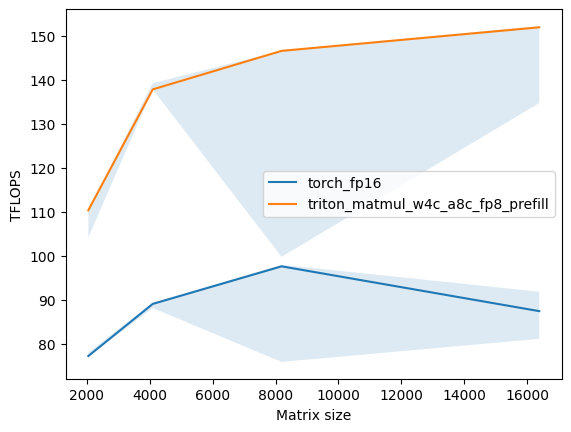

In [11]:
BS = 512
sizes = [2**11, 2**12, 2**13, 2**14]
# sizes = [2**14]

experiments = [
            "torch_fp16",
            # "triton_fp8",
            # "triton_matmul_w4c_a8c_fp8",
            "triton_matmul_w4c_a8c_fp8_prefill",
            # "triton_matmul_w4c_a8c_fp8_test",
            # "triton_matmul_w4c_a8c_fp8_T",
            ]

configs = []
configs.append(
    triton.testing.Benchmark(
        x_names=["K", "M", "N"],
        x_vals=[(size, BS, size) for size in sizes],
        line_arg="provider",
        line_vals=experiments,
        line_names=experiments,
        ylabel="TFLOPS",
        xlabel="Matrix size",
        plot_name="matmul-performance",
        args={},
    ))


@triton.testing.perf_report(configs)
def benchmark(M, K, N, provider):
    y_fp16 = torch.randn(M, K, dtype=torch.float16, device="cuda") / (M * K)
    x_fp16 = torch.randn(K, N, dtype=torch.float16, device="cuda") / (M * K)
    
    y_fp8 = torch.randn(M, K, dtype=torch.float16, device="cuda").to(torch.float8_e4m3fn)
    x_fp8 = torch.randn(K, N, dtype=torch.float16, device="cuda").T.to(torch.float8_e4m3fn)

    x_compressed_4bit = torch.randint(-2**31, 2**31, (K // 8, N), dtype=torch.int32, device="cuda")
    x_compressed_4bit_T = torch.randint(-2**31, 2**31, (N, K // 8), dtype=torch.int32, device="cuda").T
    
    x_compressed_4bit_test = torch.randint(-128, 128, (K // 2, N), dtype=torch.int8, device="cuda")
    x_compressed_4bit_test_T = torch.randint(-128, 128, (N, K // 2), dtype=torch.int8, device="cuda").T
    
    
    channel_scale = torch.randn(N, dtype=torch.float16, device="cuda").abs()
    
    quantiles = [0.5, 0.2, 0.8]
    if provider == "torch_fp16":
        print(f"\n[M x K x N]: [{M} x {K} x {N}]")
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: torch.matmul(y_fp16, x_fp16), quantiles=quantiles)
    
    if provider == "triton_fp8":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul_fp8(y_fp8, x_fp8), quantiles=quantiles)
        # print("matmul_kernel:", matmul_kernel.best_config)

    if provider == "triton_matmul_w4c_a8c_fp8_prefill":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul_w4c_a8c_fp8_prefill(y_fp8, x_compressed_4bit, channel_scale), quantiles=quantiles)
        print("MATMUL_W4C_A8C_FP8_prefill:", MATMUL_W4C_A8C_FP8_prefill.best_config)

    if provider == "triton_matmul_w4c_a8c_fp8":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul_w4c_a8c_fp8(y_fp8, x_compressed_4bit, channel_scale), quantiles=quantiles)
        print("MATMUL_W4C_A8C_FP8:", MATMUL_W4C_A8C_FP8.best_config)

    if provider == "triton_matmul_w4c_a8c_fp8_test":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul_w4c_a8c_fp8_test(y_fp8, x_compressed_4bit_test, channel_scale), quantiles=quantiles)
        print("MATMUL_W4C_A8C_FP8_test:", MATMUL_W4C_A8C_FP8_test.best_config)

    if provider == "triton_matmul_w4c_a8c_fp8_T":
        ms, min_ms, max_ms = triton.testing.do_bench(lambda: matmul_w4c_a8c_fp8(y_fp8, x_compressed_4bit_T, channel_scale), quantiles=quantiles)
        print("MATMUL_W4C_A8C_FP8:", MATMUL_W4C_A8C_FP8.best_config)


    perf = lambda ms: 2 * M * N * K * 1e-12 / (ms * 1e-3)
    return perf(ms), perf(max_ms), perf(min_ms)

bench_data = benchmark.run(show_plots=False, print_data=True, return_df=True)[0]

In [12]:
def add_speedup_columns(df):
    df_result = df.copy()
    base_column = 'torch_fp16'
    
    new_column_order = []

    # new_column_order.append("torch_fp16")
        
    for column in df.columns:
        new_column_order.append(column)
        if column not in ['K', 'M', 'N', base_column]:
            speedup_column = f"{column}_speedup"
            df_result[speedup_column] = df[column] / df[base_column]
            new_column_order.append(speedup_column)

    df_result = df_result[new_column_order]
    return df_result

add_speedup_columns(bench_data)

,K,M,N,torch_fp16,triton_matmul_w4c_a8c_fp8_prefill,triton_matmul_w4c_a8c_fp8_prefill_speedup
0,2048.0,512.0,2048.0,77.269851,110.376426,1.428454
1,4096.0,512.0,4096.0,89.107205,137.835918,1.546855
2,8192.0,512.0,8192.0,97.643961,146.585917,1.501229
3,16384.0,512.0,16384.0,87.467196,151.940113,1.737110
